## Recommneders 라이브러리를 이용 
- Recommenders는 Microsoft에서 제공하는 추천 시스템 라이브러리이다 이 라이브러리는 TensorFlow 2.0과 PyTorch를 기반으로 하며, 다양한 추천 시스템 알고리즘을 구현하고 있다.
https://github.com/microsoft/recommenders/blob/main/examples/02_model_collaborative_filtering/lightgcn_deep_dive.ipynb

In [1]:
from google.colab import drive
drive.mount("/content/myDrive")

Mounted at /content/myDrive


In [2]:
!pip install scrapbook
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 339.0/339.0 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.3/149.3 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 KB 31.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 KB 55.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 58.8 MB/s eta 0

In [3]:
import sys
import os
import scrapbook as sb
import pandas as pd
import numpy as np
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.models.deeprec.deeprec_utils import prepare_hparams

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

System version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Pandas version: 1.4.4
Tensorflow version: 2.12.0


In [4]:
# 상위 K개의 아이템 추천
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# Model parameters
EPOCHS = 50
BATCH_SIZE = 1024

SEED = DEFAULT_SEED  # Set None for non-deterministic results

yaml_file = "/content/myDrive/MyDrive/UROP/LightGCN/LightGCN_Recommneder_Microsoft/lightgcn.yaml"
user_file = "/content/myDrive/MyDrive/UROP/LightGCN/LightGCN_Recommneder_Microsoft/user_embeddings.csv"
item_file = "/content/myDrive/MyDrive/UROP/LightGCN/LightGCN_Recommneder_Microsoft/item_embeddings.csv"

# Step1. 데이터 준비
600명의 사용자가 9000개의 영화에 대해 1에서 5까지의 정수 등급으로 평가한 100000개의 평가 데이터가 존재하는 MovieLens100k 데이터 세트를 사용

In [5]:
df = movielens.load_pandas_df(size=MOVIELENS_DATA_SIZE)

df.head()

100%|██████████| 4.81k/4.81k [00:00<00:00, 15.9kKB/s]


,userID,itemID,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


### 데이터 분할
SAR은 사용자 선호도에 기반하여 추천을 생성하기 때문에, 테스트 세트에 있는 모든 사용자는 학습 세트에도 있어야 합니다. 이를 위해 python_stratified_split 함수를 사용하여 각 사용자의 항목 중 일부(이 경우 25%)를 보류하고, 모든 사용자가 학습 및 테스트 데이터셋에 모두 포함되도록 할 수 있습니다. 데이터셋.python_splitters 모듈에서는 분할 방법을 더욱 세밀하게 제어할 수 있는 다른 옵션이 제공됩니다.

- SAR은 사용자 간의 관계를 고려하여 항목 추천을 수행하기 때문에, 다른 추천 알고리즘과 달리, 비슷한 관심사를 가진 사람들끼리 항목을 추천하는 "커뮤니티"를 형성할 수 있습니다. 이러한 커뮤니티 기반 추천은 일반적으로 사용자 개인의 선호도만 고려하는 추천 알고리즘보다 정확도가 높은 추천을 제공할 수 있습니다.

In [6]:
train, test = python_stratified_split(df, ratio=0.75)
print(train.shape)
print(test.shape)

(74992, 4)
(25008, 4)


In [7]:
train.head(3)

,userID,itemID,rating,timestamp
3733,1,31,3.0,875072144
15932,1,39,4.0,875072173
9382,1,163,4.0,875072442


In [8]:
test.head(3)

,userID,itemID,rating,timestamp
27949,1,239,4.0,878542845
9566,1,210,4.0,878542909
47521,1,192,4.0,875072547


### 데이터 프레임을 희소행렬로 변환

ImplicitCF 함수는 implicit 라이브러리에서 제공하는 잠재 요인 협업 필터링 알고리즘을 구현한 클래스입니다. 이 클래스의 생성자에는 train, test, seed와 같은 파라미터가 입력됩니다.

- train: 학습 데이터셋을 나타내는 scipy.sparse 희소 행렬 형태의 객체입니다. 이 행렬은 사용자-항목 간의 상호작용 정보를 저장하고 있습니다.
- test: 테스트 데이터셋을 나타내는 scipy.sparse 희소 행렬 형태의 객체입니다. 이 행렬은 사용자-항목 간의 상호작용 정보를 저장하고 있으며, 학습 데이터셋과는 다른 일부 상호작용 정보를 가지고 있습니다.
- seed: 재현성을 위한 랜덤 시드 값입니다. 이 값을 고정하면 동일한 결과를 재현할 수 있습니다.

In [9]:
data = ImplicitCF(train=train, test=test, seed=SEED)
print(data)

/usr/local/lib/python3.9/dist-packages/recommenders/models/deeprec/DataModel/ImplicitCF.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = train if test is None else train.append(test)


### LightGCN 모델을 학습하기 위한 하이퍼파라미터를 생성

함수에 입력되는 파라미터는 다음과 같습니다.

- yaml_file: LightGCN 모델의 기본 하이퍼파라미터 값이 저장된 yaml 파일 경로입니다.
- n_layers: LightGCN 모델의 레이어 개수입니다. 기본값은 3으로 설정되어 있습니다.
- batch_size: 학습 시 사용할 배치 크기입니다.
- epochs: 학습할 epoch 횟수입니다.
- learning_rate: 학습 시 사용할 학습률입니다.
- eval_epoch: 검증을 수행할 epoch 주기입니다.
- top_k: 추천 상위 K개의 항목을 반환할 때 사용되는 K 값입니다.

이 함수는 LightGCN 모델의 학습을 위한 하이퍼파라미터를 반환합니다. 이를 hparams 변수에 저장하여, 학습 과정에서 이 값을 참조하여 모델을 학습하고 검증합니다.

In [10]:
hparams = prepare_hparams(yaml_file,
                          n_layers=3,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          learning_rate=0.005,
                          eval_epoch=5,
                          top_k=TOP_K,
                         )

# Step2. 모델 학습

In [11]:
model = LightGCN(hparams, data, seed=SEED)

Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.


In [12]:
with Timer() as train_time:
    model.fit()

print("Took {} seconds for training.".format(train_time.interval))

Epoch 1 (train)1.9s: train loss = 0.46985 = (mf)0.46960 + (embed)0.00025
Epoch 2 (train)1.2s: train loss = 0.28470 = (mf)0.28405 + (embed)0.00066
Epoch 3 (train)1.7s: train loss = 0.25343 = (mf)0.25260 + (embed)0.00082
Epoch 4 (train)2.2s: train loss = 0.23669 = (mf)0.23570 + (embed)0.00099
Epoch 5 (train)2.1s + (eval)4.7s: train loss = 0.23210 = (mf)0.23100 + (embed)0.00111, recall = 0.15584, ndcg = 0.34174, precision = 0.29703, map = 0.08969
Epoch 6 (train)1.4s: train loss = 0.22394 = (mf)0.22274 + (embed)0.00120
Epoch 7 (train)0.7s: train loss = 0.21258 = (mf)0.21126 + (embed)0.00132
Epoch 8 (train)0.7s: train loss = 0.20166 = (mf)0.20020 + (embed)0.00146
Epoch 9 (train)0.7s: train loss = 0.18874 = (mf)0.18712 + (embed)0.00161
Epoch 10 (train)0.8s + (eval)0.2s: train loss = 0.18451 = (mf)0.18273 + (embed)0.00178, recall = 0.17787, ndcg = 0.38410, precision = 0.33521, map = 0.10577
Epoch 11 (train)0.8s: train loss = 0.17410 = (mf)0.17217 + (embed)0.00193
Epoch 12 (train)0.8s: train l

# Step3. 모델 평가

이 함수에서 전달된 각 사용자에 대해 추천 항목을 k개씩 추천하기 위해 recommend_k_items를 호출한다. 사용자가 이미 본 항목을 제거하려면 remove_seen=True로 설정하면 된다. 이 함수는 각 사용자와 이 사용자에게 추천된 상위 k개 항목 및 해당 순위 점수를 포함하는 데이터 프레임을 반환한다.

In [13]:
topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

topk_scores.head()

,userID,itemID,prediction
0,1,7,5.792502
1,1,475,5.483119
2,1,919,5.352048
3,1,89,5.296584
4,1,1,5.276995


### 성능 평가

In [14]:
eval_map = map_at_k(test, topk_scores, k=TOP_K)
eval_ndcg = ndcg_at_k(test, topk_scores, k=TOP_K)
eval_precision = precision_at_k(test, topk_scores, k=TOP_K)
eval_recall = recall_at_k(test, topk_scores, k=TOP_K)

print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.135738
NDCG:	0.455456
Precision@K:	0.400424
Recall@K:	0.213484


- MAP 값이 0.135305이고, 이는 평균 정밀도(mean average precision)를 의미합니다. 추천 시스템에서 사용자가 관심을 가진 아이템이 상위에 노출될수록 성능이 더 좋다는 것을 나타냅니다. MAP 값이 0에 가까울수록 추천 성능이 낮다는 것을 의미합니다.
- NDCG 값이 0.453004이고, 이는 정규화 누적 할인 이익(normalized discounted cumulative gain)을 의미합니다. 추천 시스템에서 사용자가 상위 아이템에 대해 더 높은 관심을 가질수록 성능이 더 좋다는 것을 나타냅니다. NDCG 값이 1에 가까울수록 추천 성능이 높다는 것을 의미합니다.
- Precision@K 값이 0.399258이고, 이는 정밀도(precision)를 의미합니다. 추천 시스템에서 사용자가 상위 K개의 아이템 중 실제로 관심을 가진 아이템의 비율을 의미합니다. Precision 값이 1에 가까울수록 추천 성능이 높다는 것을 의미합니다.
- Recall@K 값이 0.213203이고, 이는 재현율(recall)을 의미합니다. 추천 시스템에서 사용자가 실제로 관심을 가진 아이템 중 상위 K개의 아이템이 추천 결과에 얼마나 포함되었는지를 나타냅니다. Recall 값이 1에 가까울수록 추천 성능이 높다는 것을 의미합니다.

In [15]:
# Record results with papermill for tests
sb.glue("map", eval_map)
sb.glue("ndcg", eval_ndcg)
sb.glue("precision", eval_precision)
sb.glue("recall", eval_recall)

### 임베딩 추론

이 함수는 해당 파일들에서 ID를 읽어들인 후, 모델에서 추론된 사용자와 아이템 임베딩을 반환합니다.

이 함수를 사용하면 훈련된 모델에서 학습되지 않은 새로운 사용자나 아이템에 대한 임베딩을 추론할 수 있습니다.

In [16]:
model.infer_embedding(user_file, item_file)

# Step4. Compare LightGCN with SAR and NCF
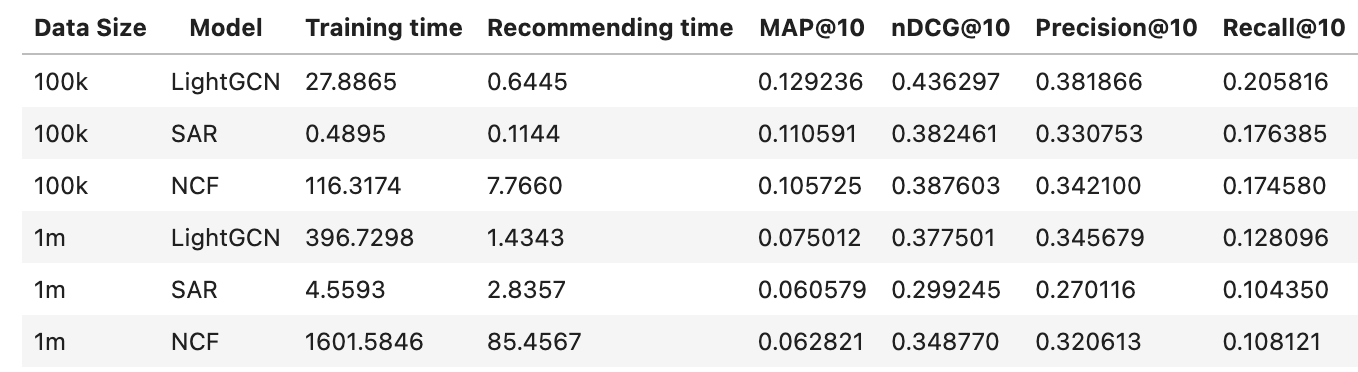